# ML Classifier Copies - Image Recognition Model Autoencoder Example

An example where we take a classifier model of the publicly available [MNIST Handwritten Digits Dataset](http://yann.lecun.com/exdb/mnist/) that we can query in order to obtain a copy. Although we **did** build this model, and we do have in fact all information, we treat it as a "black box" model to illustrate the capabilities of the ML classifier copies package.

Here we illustrate how to use the image autoencoder included in the ML Classifier Copies package in order to explore the feature space more efficiently when carrying out the ML classifier copy.

<a name="Index">
    
----
# Table of contents


1. [**Load original model**](#Original)
2. [**Sampling strategies**](#Sampling)  
    A. [**Sampling randomly**](#Random)  
    B. [**Sampling with an autoencoder**](#Autoencoder)  
      1. [**Alternate realistic dataset**](#Alternate)
      2. [**Instantiate and train autoencoder**](#Train)  
      3. [**Generation of synthetic images with autoencoder**](#Synthetic)
3. [**Build copies**](#Copy)
4. [**Evaluate copies**](#Evaluation)
----

In [2]:
import sys
sys.path.append("../../")

In [174]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import random
import requests
import zipfile

from tensorflow.keras import callbacks

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from presc.dataset import Dataset
from presc.copies.autoencoders import ImageVAE, plot_autoencoder_latent_space
from presc.copies.copying import ClassifierCopy
from presc.copies.sampling import image_random_sampling, image_vae_sampling, labeling

from ML_copies_original_models import CustomFlattener, DigitsModel

In [4]:
# Needed in some computers
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
def show_images(images):
    nrows = int(np.ceil(len(images)/5))
    _, axs = plt.subplots(nrows=nrows, ncols=5, figsize=(12, 2.4*nrows))
    axs = axs.flatten()
    for img, ax in zip(images, axs):
        ax.imshow(img)
    for n in range(len(images), len(axs)):
        axs[n].set_visible(False)
    plt.show()

[Index](#Index)  
  
  


<a name="Original">  

-----
-----
# Load original model

We load a "black box" classifier model that we can query for the labels of any points. This may take a couple of minutes.

In [6]:
digits_model = DigitsModel()

Performance of the original model:

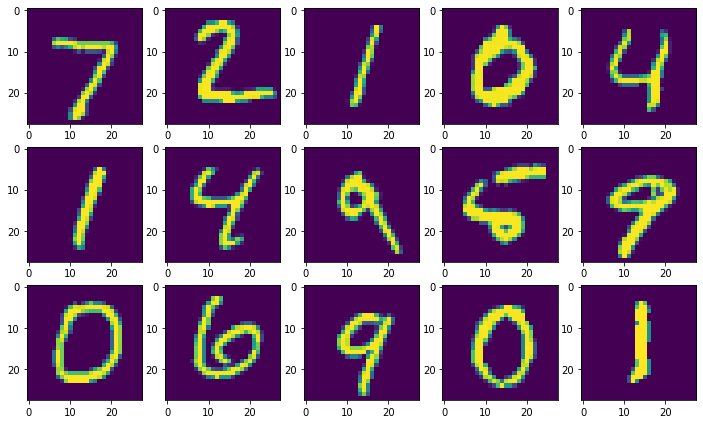

In [7]:
show_images(digits_model.X_test["images"][:15])

In [8]:
digits_model.model.predict(digits_model.X_test[:15])

array([7, 2, 1, 0, 4, 1, 4, 9, 6, 9, 0, 6, 9, 0, 1])

[Index](#Index)  
  
  


<a name="Sampling">  

-----
# Sampling

In order to carry out the copy, we first need to sample the feature space. However, even small image samples very quickly start to have a huge number of dimensions when expressed in the form of the intensity or color values at each pixel. Therefore, it is difficult to optimize the sampling process during the copy so that we generate relevant samples which are near the boundaries of the original ML classifier.

Although the original dataset is not needed for the copy, in cases such as this, where there are a large number dimensions of the feature space, more information of the original data distribution is needed.

If unlabeled samples from the original sample distribution are available, we can use those to carry out the copy. But if this is not the case, we can still carry out a good copy using a variational autoencoder if we have an unlabeled dataset with data that "makes sense" (that is, that occupies the same manifold as the original data).

Here, we show the limitations of random data samplers to copy image ML classifiers, and how to use the variational autoencoder included in the ML classifier copies package to explore the feature space more efficiently.

<a name="Random">  

## Sampling using random values

A simple option to sample the feature space, albeit not efficient for most image problems where images have structure, is to generate a synthetic dataset using a random uniform distribution to determine the value for each pixel.

In [139]:
random_samples = image_random_sampling(nsamples=100)

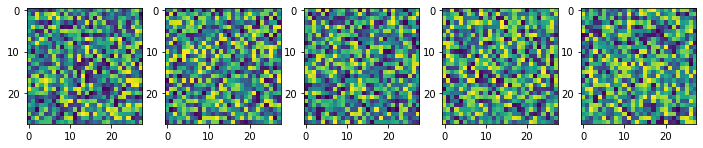

In [140]:
show_images(random_samples["images"][0:5])

The problem is that these images are not relevant to determine the original ML classifier boundaries. They are images exploring a region of the feature space that is not relevant for the classification task.

Apart from the images not being representative, if we label the random images using the original model we can see that, additionally, not all the classes are represented. Which is obvious in this extreme case, but which can also happen when sampling randomly with an intermediate number of dimensions.

In [141]:
random_labeled_datset = labeling(random_samples, digits_model.model, label_col="digit")

In [142]:
random_labeled_datset.df["digit"].unique()

[5, 2]
Categories (2, int64): [5, 2]

[Index](#Index)  
  
  


<a name="Autoencoder">  

## Sampling using a variational autoencoder

The variational autoencoder allows to represent the sample manifold (the relevant regions of the feature space) with much fewer dimensions, in this case using a Gaussian distribution per latent factor, and then generate random samples from these distributions. This means that the relevant regions of the feature space can be sampled much more efficiently in order to carry out the ML classifier copy.

To use a variational autoencoder for the sampling of the feature space it is necessary to previously train it with realistic samples. However, it is not necessary that this data has any labels.

In the best case scenario that a subgroup of original samples is available, this is a perfect option to train the autoencoder (they should be labeled first using the "labeling" function).

<a name="Alternate"> 

### Alternate realistic datset

We will use samples from the [Handwritten Digit Dataset](https://github.com/JC-ProgJava/Handwritten-Digit-Dataset), which is another digit dataset different from MNIST that is generated automatically with data augmentation using only 10 handwritten digits. The user can even generate her own dataset [here](https://jc-progjava.github.io/Handwritten-Digit-Dataset/).

In [13]:
url = ("https://github.com/JC-ProgJava/Handwritten-Digit-Dataset"
       "/releases/download/v1.0.0/dataset.zip")
compressed_file = zipfile.ZipFile(io.BytesIO(requests.get(url).content))

In [14]:
image_files = list(filter(lambda x: (".png" in x and "MACOSX" not in x and "dataset/1/1\\310.png" not in x),
                          compressed_file.namelist()))
images_sample = random.sample(image_files, 40000)

In [15]:
digit_images = [None] * len(images_sample)
pointer = 0
for name in images_sample:
    digit_images[pointer] = np.asarray(PIL.Image.open(compressed_file.open(name)))[:, :, 3]
    pointer += 1
alternative_digits = pd.DataFrame({"images": digit_images})

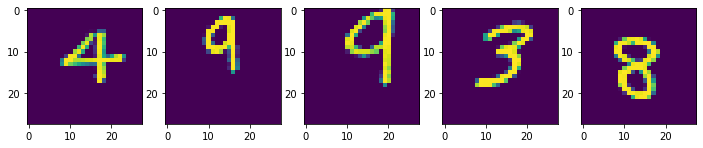

In [22]:
show_images(alternative_digits["images"].sample(5))

[Index](#Index)  
  


<a name="Train">  

### Instantiate and train autoencoder

In [17]:
# Prepare image dataset for autoencoder training input
digit_images_tf = np.expand_dims((alternative_digits["images"]).to_list(), -1) / 255

In [18]:
# Configure early stopping to avoid overfitting
early_stopping = callbacks.EarlyStopping(monitor ="loss", mode ="min", patience = 10, restore_best_weights = True)

In [206]:
# Instantiate variational autoencoder with 3 latent dimensions
digit_autoencoder = ImageVAE(input_shape=(28, 28, 1), latent_dim=3, 
                             optimizer=tf.keras.optimizers.RMSprop(centered=True), kl_multiplicative_factor=1)

In [207]:
# Fit autoencoder using only 9600 samples
fit_history = digit_autoencoder.fit(digit_images_tf[:9600], epochs=200, batch_size=32,
                                    callbacks =[early_stopping])

Epoch 1/200
300/300 [==============================] - 2s 5ms/step - loss: 182.6228 - reconstruction_loss: 137.1343 - kl_loss: 3.8517
Epoch 2/200
300/300 [==============================] - 1s 5ms/step - loss: 112.9706 - reconstruction_loss: 104.7163 - kl_loss: 5.5684
Epoch 3/200
300/300 [==============================] - 1s 5ms/step - loss: 105.1893 - reconstruction_loss: 98.6088 - kl_loss: 6.3733
Epoch 4/200
300/300 [==============================] - 1s 5ms/step - loss: 102.6224 - reconstruction_loss: 95.3198 - kl_loss: 6.6219
Epoch 5/200
300/300 [==============================] - 1s 5ms/step - loss: 100.1594 - reconstruction_loss: 92.7060 - kl_loss: 6.8880
Epoch 6/200
300/300 [==============================] - 2s 5ms/step - loss: 97.9348 - reconstruction_loss: 90.4535 - kl_loss: 7.0887
Epoch 7/200
300/300 [==============================] - 1s 5ms/step - loss: 95.9578 - reconstruction_loss: 88.4474 - kl_loss: 7.2845
Epoch 8/200
300/300 [==============================] - 1s 5ms/step - 

300/300 [==============================] - 2s 6ms/step - loss: 70.7703 - reconstruction_loss: 61.0249 - kl_loss: 9.7842
Epoch 63/200
300/300 [==============================] - 2s 5ms/step - loss: 70.6154 - reconstruction_loss: 60.9666 - kl_loss: 9.8337
Epoch 64/200
300/300 [==============================] - 2s 5ms/step - loss: 70.0560 - reconstruction_loss: 60.8019 - kl_loss: 9.8071
Epoch 65/200
300/300 [==============================] - 2s 6ms/step - loss: 70.2212 - reconstruction_loss: 60.5790 - kl_loss: 9.8439
Epoch 66/200
300/300 [==============================] - 2s 6ms/step - loss: 70.4473 - reconstruction_loss: 60.4915 - kl_loss: 9.8548
Epoch 67/200
300/300 [==============================] - 2s 6ms/step - loss: 70.0535 - reconstruction_loss: 60.2910 - kl_loss: 9.8761
Epoch 68/200
300/300 [==============================] - 2s 6ms/step - loss: 70.0063 - reconstruction_loss: 60.2850 - kl_loss: 9.8887
Epoch 69/200
300/300 [==============================] - 2s 5ms/step - loss: 69.640

300/300 [==============================] - 2s 6ms/step - loss: 64.5194 - reconstruction_loss: 54.6418 - kl_loss: 10.3057
Epoch 124/200
300/300 [==============================] - 2s 5ms/step - loss: 64.7318 - reconstruction_loss: 54.5310 - kl_loss: 10.3309
Epoch 125/200
300/300 [==============================] - 2s 6ms/step - loss: 64.5495 - reconstruction_loss: 54.4472 - kl_loss: 10.3162
Epoch 126/200
300/300 [==============================] - 2s 5ms/step - loss: 64.3834 - reconstruction_loss: 54.4065 - kl_loss: 10.2935
Epoch 127/200
300/300 [==============================] - 2s 6ms/step - loss: 64.2694 - reconstruction_loss: 54.3830 - kl_loss: 10.3424
Epoch 128/200
300/300 [==============================] - 2s 5ms/step - loss: 64.1086 - reconstruction_loss: 54.2941 - kl_loss: 10.3177
Epoch 129/200
300/300 [==============================] - 2s 5ms/step - loss: 64.4735 - reconstruction_loss: 54.2510 - kl_loss: 10.3596
Epoch 130/200
300/300 [==============================] - 2s 5ms/step 

300/300 [==============================] - 2s 6ms/step - loss: 61.9888 - reconstruction_loss: 51.5036 - kl_loss: 10.5622
Epoch 184/200
300/300 [==============================] - 2s 6ms/step - loss: 61.4310 - reconstruction_loss: 51.3934 - kl_loss: 10.5592
Epoch 185/200
300/300 [==============================] - 2s 6ms/step - loss: 61.2370 - reconstruction_loss: 51.3938 - kl_loss: 10.5515
Epoch 186/200
300/300 [==============================] - 2s 6ms/step - loss: 61.8989 - reconstruction_loss: 51.2063 - kl_loss: 10.5725
Epoch 187/200
300/300 [==============================] - 2s 6ms/step - loss: 61.5584 - reconstruction_loss: 51.2597 - kl_loss: 10.5520
Epoch 188/200
300/300 [==============================] - 2s 6ms/step - loss: 61.6578 - reconstruction_loss: 51.1367 - kl_loss: 10.5475
Epoch 189/200
300/300 [==============================] - 2s 6ms/step - loss: 61.6151 - reconstruction_loss: 51.1911 - kl_loss: 10.5572
Epoch 190/200
300/300 [==============================] - 2s 6ms/step 

[Index](#Index)  
  
  


<a name="Synthetic">  

### Generation of synthetic images with autoencoder

The Variational Autoencoder allows to generate a range of continuous synthetic samples using its representation of the latent space, which can then be labeled using the original classifier.

In [208]:
image_features = {"images": {"x_pixels": 28, "y_pixels": 28, "min": 0, "max": 254, 
                             "autoencoder": digit_autoencoder, "autoencoder_latent_dim": 3,
                             "autoencoder_edge_factor": 5}}
synthetic_autoencoder_images = image_vae_sampling(nsamples=200, feature_parameters=image_features)

In [209]:
autoencoder_labeled_datset = labeling(synthetic_autoencoder_images, digits_model.model, label_col="labels")

A hint that the synthetic image samples generated by the autoencoder show a good ability to probe the relevant feature space is that all classes are represented in the sample.

In [210]:
autoencoder_labeled_datset.df["labels"].unique()

[2, 8, 5, 1, 3, 7, 4, 9, 6, 0]
Categories (10, int64): [2, 8, 5, 1, ..., 4, 9, 6, 0]

* Below there are some examples of latent space representation across pairs of dimensions.

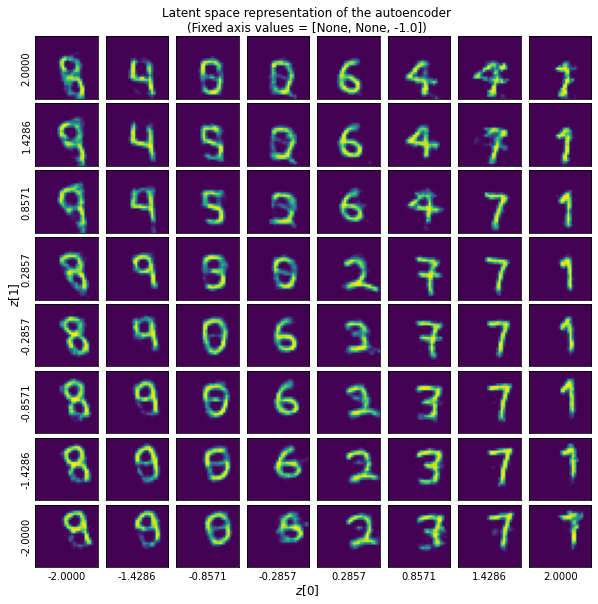

In [223]:
plot_autoencoder_latent_space(digit_autoencoder, x_plot=0, y_plot=1, all_axes=[None,None,-1.], size=1, n_images=8)

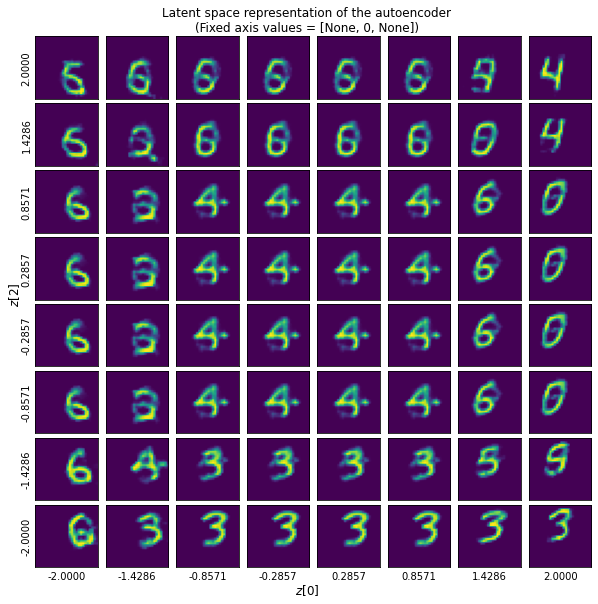

In [221]:
plot_autoencoder_latent_space(digit_autoencoder, x_plot=0, y_plot=2, all_axes=[None,0,None], size=1, n_images=8)

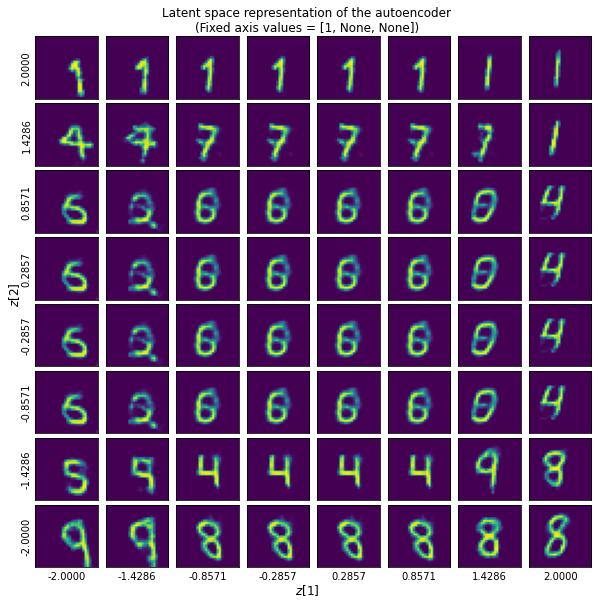

In [224]:
plot_autoencoder_latent_space(digit_autoencoder, x_plot=1, y_plot=2, all_axes=[1,None,None], size=1, n_images=8)

[Index](#Index)  
  
  


<a name="Copies">  

-----
# Build copies

We build two copies: one sampling the feature space using the random image generator, and the other using the variational autoencoder image generator.

### Random images

In [108]:
image_features = {"images": {"x_pixels": 28, "y_pixels": 28, "min": 0, "max": 253}}

In [109]:
log_random_classifier = Pipeline([('flattener', CustomFlattener()), ('log_classifier',
                                   LogisticRegression(max_iter=1000))])

In [111]:
log_random_copy = ClassifierCopy(digits_model.model, log_random_classifier, image_random_sampling,
                                 enforce_balance=False, nsamples=2000, random_state=42,
                                 feature_parameters=image_features, label_col="labels")
log_random_copy_training_data = log_random_copy.copy_classifier(get_training_data=True)

### Autoencoder images

In [199]:
image_features = {"images": {"x_pixels": 28, "y_pixels": 28, "min": 0, "max": 254,
                             "autoencoder": digit_autoencoder, "autoencoder_latent_dim": 3,
                             "autoencoder_edge_factor": 5}}

In [201]:
log_vae_classifier = Pipeline([('flattener', CustomFlattener()), ('log_classifier',
                                   LogisticRegression(max_iter=3000))])

In [ ]:
log_vae_copy = ClassifierCopy(digits_model.model, log_vae_classifier, image_vae_sampling,
                                 enforce_balance=False, nsamples=10000, random_state=42,
                                 feature_parameters=image_features, label_col="labels")
log_vae_copy_training_data = log_vae_copy.copy_classifier(get_training_data=True)

[Index](#Index)  
  
  


<a name="Evaluation">  

-----
# Evaluate copies

As can be seen, the ML classifier copy carried out using a variational autoencoder sampler has a much better performance than randomly sampling the space. This autoencoder could be further optimized to sample the space even better and obtain a higher performance of the copy.

### Random images

In [112]:
print("\n * Logistic regression copy:")
synthetic_log_random_test_data = log_random_copy.generate_synthetic_data(nsamples=500, random_state=43)
evaluation_log_random_copy = log_random_copy.evaluation_summary(
    test_data=Dataset(digits_model.X_test.join(digits_model.y_test), label_col="labels"),
    synthetic_data=synthetic_log_random_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9792
Copy Model Accuracy (test)              0.1638
Empirical Fidelity Error (synthetic)    0.1740
Empirical Fidelity Error (test)         0.8358
Replacement Capability (synthetic)      0.8260
Replacement Capability (test)           0.1673


### Autoencoder images

In [203]:
print("\n * Logistic regression copy:")
synthetic_log_vae_test_data = log_vae_copy.generate_synthetic_data(nsamples=1000, random_state=43)
evaluation_log_vae_copy = log_vae_copy.evaluation_summary(
    test_data=Dataset(digits_model.X_test.join(digits_model.y_test).sample(1000), label_col="labels"),
    synthetic_data=synthetic_log_vae_test_data)


 * Logistic regression copy:
Original Model Accuracy (test)          0.9720
Copy Model Accuracy (test)              0.6360
Empirical Fidelity Error (synthetic)    0.1160
Empirical Fidelity Error (test)         0.3570
Replacement Capability (synthetic)      0.8840
Replacement Capability (test)           0.6543


[Index](#Index)  
  
  


-----
-----